# Pseudotime Spatial Trajectory Inference with Xenium Data

We will go through the tutorial on how to use stLearn to perform clustering (with or without imputation) and spatial trajectories inference with Xenium data from 10X Genomics. The main dataset we are working on is the breast cancer tumor microenvironment. You can download it here: https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast 

### 1. Loading library

In [1]:
import stlearn as st
import matplotlib.pyplot as plt
import pathlib as pathlib
import numpy as np
import random as random
import os as os

st.settings.set_figure_params(dpi=120)

# Make sure all the seeds are set
seed = 0
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/andrew/conda/stlearn/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this 

In [2]:
library_id = "Xenium_FFPE_Human_Breast_Cancer_Rep1"

In [3]:
st.settings.datasetdir =  pathlib.Path.cwd().parent / "data"

In [4]:
st.datasets.xenium_sge(library_id=library_id, include_hires_tiff=True)

### 2. Reading Xenium data

You can download all the data in the 10X Genomics resource webpage. For H&E image, because it was generated separately with the main xenium data, then you need to perform the registration by your self. Here we provide an example of a H&E image which is performed a manual registration by Dr. Soo Hee Lee. You can download it here: [Link](https://www.dropbox.com/s/th6tqqgbv27o3fk/CS1384_post-CS0_H%26E_S1A_RGB-shlee-crop.png?dl=1)

In [5]:
data_dir = st.settings.datasetdir / "Xenium_FFPE_Human_Breast_Cancer_Rep1"

adata = st.ReadXenium(feature_cell_matrix_file=data_dir / "cell_feature_matrix.h5",
                      cell_summary_file=data_dir / "cells.csv.gz",
                      library_id=library_id,
                      image_path=data_dir / "he_image.ome.tif",
                      scale=1,
                      spot_diameter_fullres=15,
                      alignment_matrix_file=data_dir / "he_imagealignment.csv",
                      experiment_xenium_file=data_dir / "experiment.xenium",
                      )

Added tissue image to the object!


In [6]:
adata

AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

### 3. Preprocessing

Here, we use scanpy to perform several steps of preprocessing

In [7]:
# Filter genes and cells with at least 10 counts
st.pp.filter_genes(adata, min_counts=10)
st.pp.filter_cells(adata, min_counts=10)

In [8]:
# Store the raw data for using PSTS
adata.raw = adata

In [9]:
# Normalization data
st.pp.normalize_total(adata)

Normalization step is finished in adata.X


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


After normalization, we have two options. One is using log transformation or square root transformation (recommend by the 10X team)

In [10]:
# Squareroot normalize transcript counts. We need to deal with sparse matrix of .X

adata.X = np.sqrt(adata.X.toarray()) + np.sqrt(adata.X.toarray() + 1)
# If the matrix is small, we don't need to convert to numpy array. I believe, Xenium data is always large 
# adata.X = csr_array(np.sqrt(adata.X) + np.sqrt(adata.X + 1))

# If you want to use log transformation, please use:
# st.pp.log1p(adata)

In [11]:
# Run PCA
st.em.run_pca(adata, n_comps=50, random_state=0)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


##### Apply stSME (optional)

stSME is optional as an imputation function. Due to the scope of this tutorial, we will not use it here, but we recommend you run if you have an H&E image in your dataset

In [12]:
# apply stSME to normalise log transformed data
# st.spatial.SME.SME_normalize(adata, use_data="raw")
# adata.X = adata.obsm['raw_SME_normalized']
# st.pp.scale(adata)
# st.em.run_pca(adata,n_comps=50)

In [13]:
# Compute neighborhood graph of cells using the PCA representation
st.pp.neighbors(adata, n_neighbors=25, use_rep='X_pca', random_state=0)

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


### 3. Clustering

Here we use `louvain` clustering. You also can use `leiden` clustering method with `scanpy.tl.leiden`.

In [14]:
st.tl.clustering.louvain(adata, random_state=0)

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


We can plot the clustering result: 

AnnData object with n_obs × n_vars = 164000 × 313
    obs: 'imagecol', 'imagerow', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial', 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

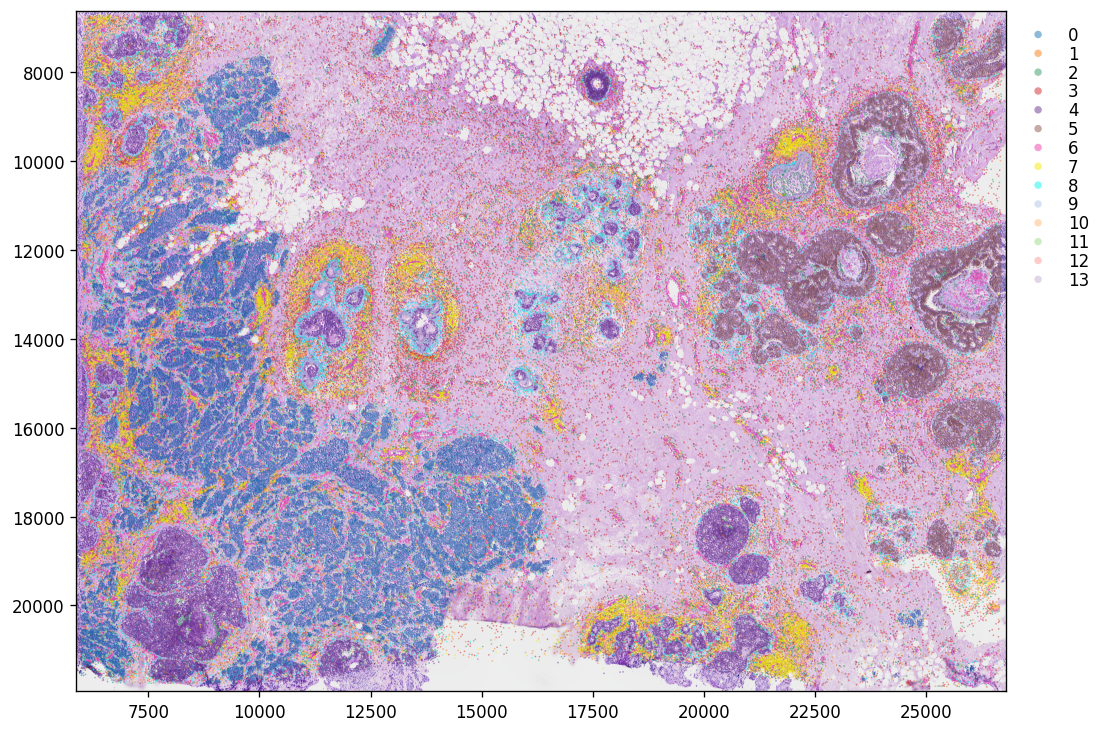

In [15]:


plt.rcParams["figure.figsize"] = (10, 10)
st.pl.cluster_plot(adata, use_label="louvain", image_alpha=1, size=1, cell_alpha=0.5, show_image=True, show_axis=True)

You can crop a region of interest with `zoom_coord` parameter.

AnnData object with n_obs × n_vars = 164000 × 313
    obs: 'imagecol', 'imagerow', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial', 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

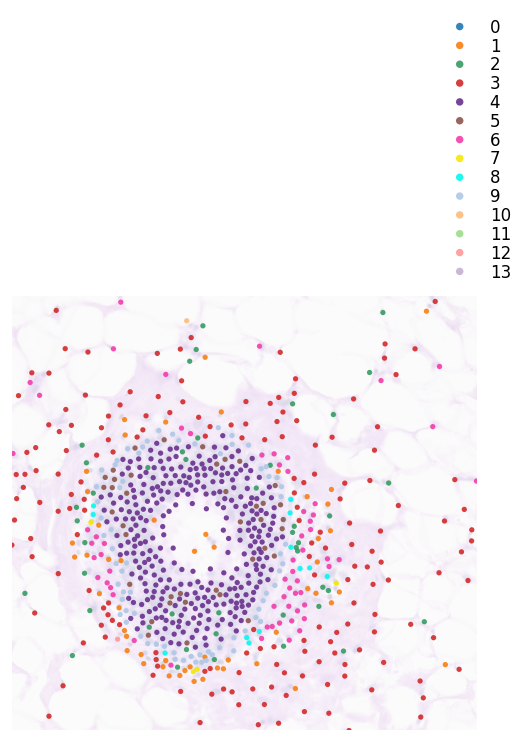

In [16]:
plt.rcParams["figure.figsize"] = (5, 5)
st.pl.cluster_plot(adata, use_label="louvain",
                   image_alpha=0.2, size=10,
                   cell_alpha=0.9,
                   zoom_coord=(17000.0, 18500.0, 7500.0, 8900.0),
                   show_color_bar=True)

### 4. PSeudo-Time-Space (PSTS) for spatial trajectory analysis

We provide PSTS for spatial trajectory analysis.

The first step is to select the root index. We allow the user to automatically select the index of the cell but still need to input which cluster should be the root cluster in your biological question.

In this tutorial, we focus on the cancer progression from Ductal carcinoma in situ (DCIS) to Invasive ductal carcinoma (IDC). That is why we choose the root cluster `6` as the DCIS cluster. 

In [17]:
adata.uns["iroot"] = st.spatial.trajectory.set_root(
    adata,
    use_label="louvain",
    cluster="4",
    use_raw=True
)
adata.uns["iroot"]

10487

For the `pseudotime` function, we are based on the diffusion pseudotime algorithm to initialize the pseudotime for trajectory at the gene expression level. `pseudotimespace_global` is the function for incorporating the spatial information to construct the (meta) trajectory in the spatial context.

In [18]:
st.spatial.trajectory.pseudotime(adata, eps=50, use_rep="X_pca", use_label="louvain")

All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


In this dataset, the IDC cluster we are looking for is the one on the edge of ducts. This part is the first layer of invasive cancer cells starting from DCIS. That's how we choose cluster `10` for the IDC.

In [19]:
st.spatial.trajectory.pseudotimespace_global(adata, use_label="louvain", list_clusters=["4", "9"])

Start to construct the trajectory: 4 -> 9


AnnData object with n_obs × n_vars = 164000 × 313
    obs: 'imagecol', 'imagerow', 'n_counts', 'louvain', 'sub_cluster_labels', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial', 'pca', 'neighbors', 'louvain', 'louvain_colors', 'iroot', 'louvain_index_dict', 'paga', 'louvain_sizes', 'diffmap_evals', 'threshold_spots', 'split_node', 'global_graph', 'centroid_dict', 'available_paths', 'PTS_graph'
    obsm: 'spatial', 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

After construct the spatial trajectories from DCIS to IDC cluster. We can observe multiple meta-trajectories with sub-clusters which generated by spatial feature. With `tree_plot`, you can show all of the detail sub-clusters ids.

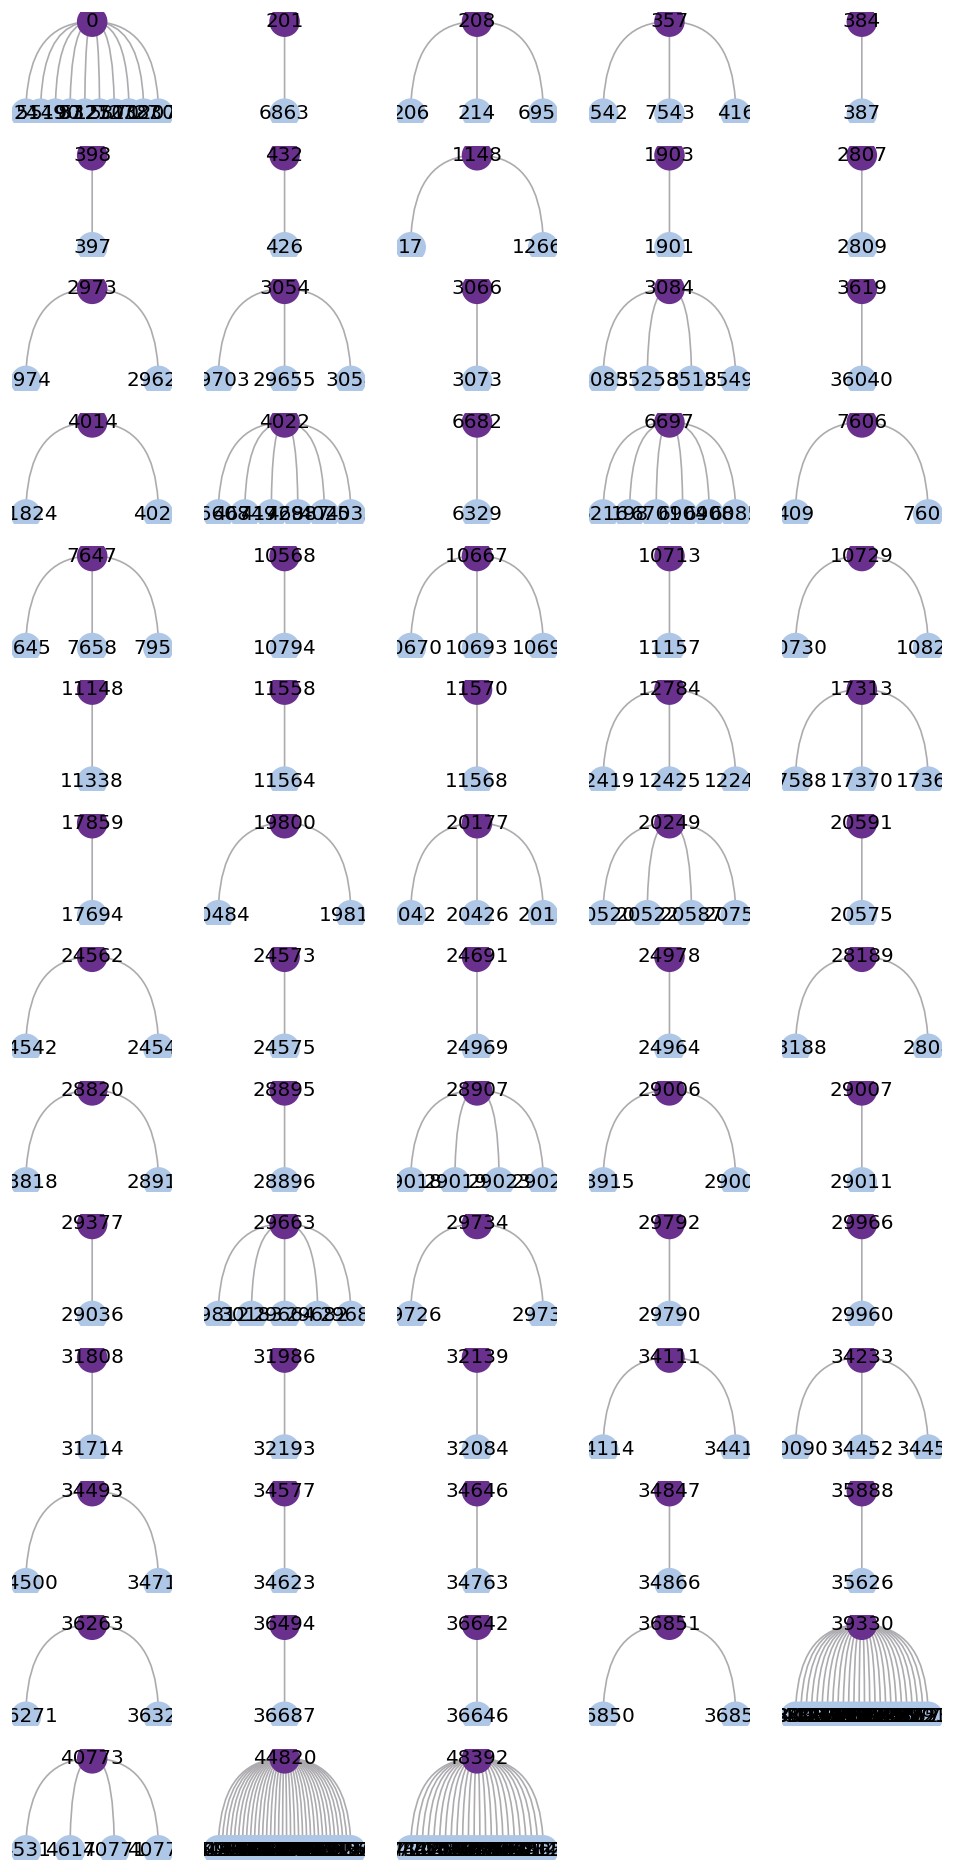

AnnData object with n_obs × n_vars = 164000 × 313
    obs: 'imagecol', 'imagerow', 'n_counts', 'louvain', 'sub_cluster_labels', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial', 'pca', 'neighbors', 'louvain', 'louvain_colors', 'iroot', 'louvain_index_dict', 'paga', 'louvain_sizes', 'diffmap_evals', 'threshold_spots', 'split_node', 'global_graph', 'centroid_dict', 'available_paths', 'PTS_graph'
    obsm: 'spatial', 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [20]:
st.pl.trajectory.tree_plot(adata, figsize=(10, 20), ncols=5)

Now, we can crop and discover the transition genes of sub-clusters meta-trajectory

AnnData object with n_obs × n_vars = 164000 × 313
    obs: 'imagecol', 'imagerow', 'n_counts', 'louvain', 'sub_cluster_labels', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial', 'pca', 'neighbors', 'louvain', 'louvain_colors', 'iroot', 'louvain_index_dict', 'paga', 'louvain_sizes', 'diffmap_evals', 'threshold_spots', 'split_node', 'global_graph', 'centroid_dict', 'available_paths', 'PTS_graph'
    obsm: 'spatial', 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

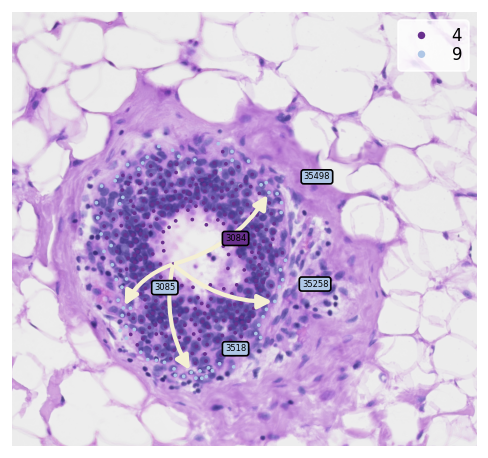

In [21]:
st.pl.cluster_plot(
    adata,
    use_label="louvain",
    show_trajectories=True,
    list_clusters=["4", "9"],
    show_subcluster=True,
    zoom_coord=(17000.0, 18500.0, 7500.0, 8900.0),
    show_node=False
)

Finding the transition markers of `clade_3019`

In [29]:
st.spatial.trajectory.detect_transition_markers_clades(adata, clade=3084, use_raw_count=False, cutoff_spearman=0.1)

Detecting the transition markers of clade_3084...
Transition markers result is stored in adata.uns['clade_3084']


Plot the transition markers, red color is down-regulated gene, blue color is up-regulated gene

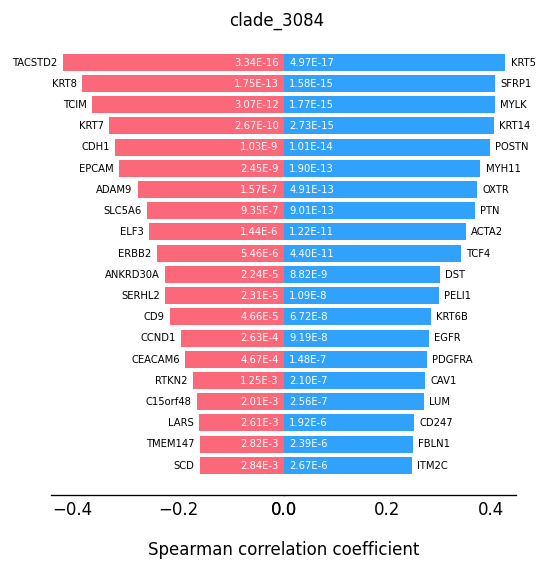

AnnData object with n_obs × n_vars = 164000 × 313
    obs: 'imagecol', 'imagerow', 'n_counts', 'louvain', 'sub_cluster_labels', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    uns: 'spatial', 'pca', 'neighbors', 'louvain', 'louvain_colors', 'iroot', 'louvain_index_dict', 'paga', 'louvain_sizes', 'diffmap_evals', 'threshold_spots', 'split_node', 'global_graph', 'centroid_dict', 'available_paths', 'PTS_graph', 'clade_29663', 'clade_3054', 'clade_3084'
    obsm: 'spatial', 'X_pca', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [30]:
plt.rcParams["figure.figsize"] = (5, 5)
st.pl.trajectory.transition_markers_plot(adata, top_genes=20, trajectory="clade_3084")

We can observe some keratinocytes family genes here as the progression markers.

### Acknowledgement

We would like to thank Soo Hee Lee and 10X Genomics team for their able support, contribution and feedback to this tutorial